In [1]:
#!pip install transformers tntorch -qqq

In [2]:
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.auto import tqdm

In [3]:
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's take arbitrary parameter matrix.

In [4]:
#w = model.encoder.layer[0].attention.self.query.weight.detach().numpy()
device = 'cuda:0'

w = model.encoder.layer[0].intermediate.dense.weight.detach().to(device)

In [5]:
w.shape

torch.Size([3072, 768])

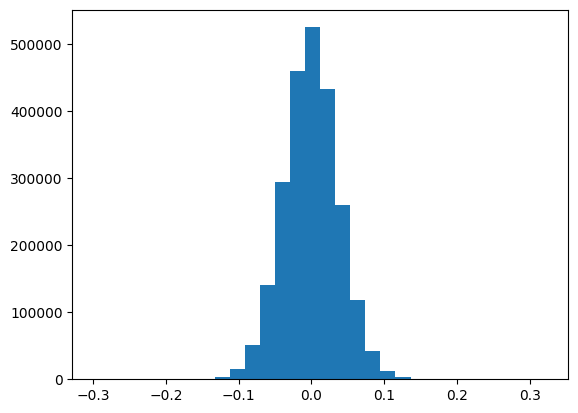

In [6]:
plt.hist(w.cpu().numpy().ravel(), bins=30)
plt.show()

In [7]:
#u, s, vt = np.linalg.svd(w)
u, s, vt = torch.linalg.svd(w, full_matrices=False)

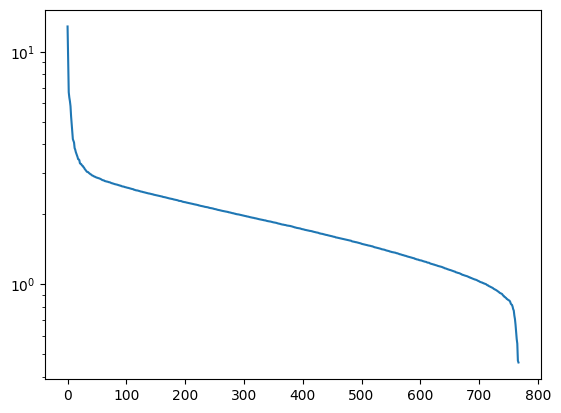

In [8]:
plt.semilogy(s.cpu())

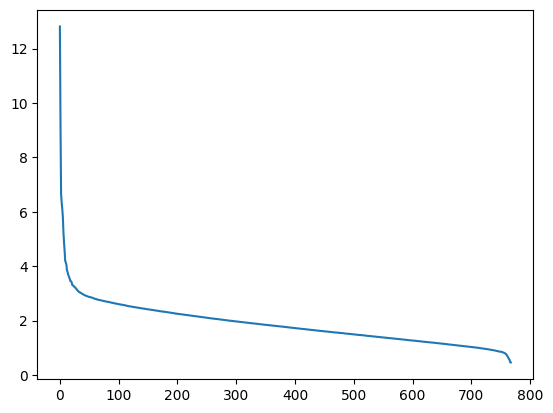

In [9]:
plt.plot(s.cpu())

It is of high rank, so haive svd should work badly.

In [10]:
def weighted_frob(a, weight):
    return torch.sqrt(torch.sum(torch.square(a) * weight)).item()

Let's generate random weights, which will serve as "Fisher information".

In [11]:
torch.manual_seed(2222)
weight = torch.rand(*w.shape) ** 100
weight /= weight.max()

Weights are 
1. from 0 to 1 (important!!!)
2. mostly zero, rarely one

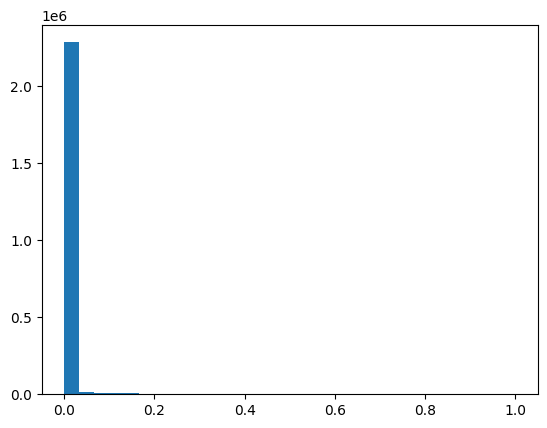

In [12]:
plt.hist(weight.numpy().ravel(), bins=30)
plt.show()

In [first article](https://arxiv.org/abs/2207.00112) authors sum elements of Fisher matrix by rows (or by columns -- maybe it should be `.sum(0)`, I'm not sure )

torch.Size([3072])


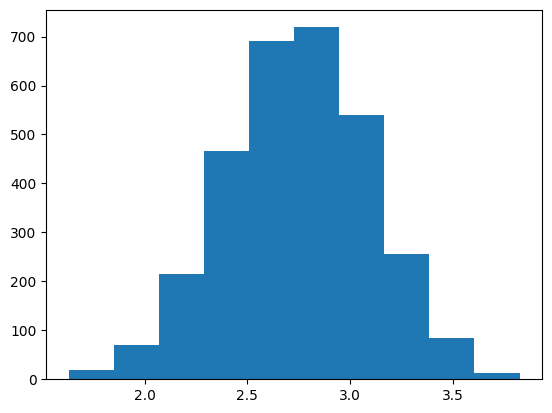

In [13]:
diag_weight = torch.sqrt(weight.sum(1))
print(diag_weight.shape)
plt.hist(diag_weight)
plt.show()

In [14]:
def get_low_rank(w, k):
    u, s, vt = torch.linalg.svd(w, full_matrices=False)
    u = u[:, :k]
    s = s[:k]
    vt = vt[:k]
    return u, torch.diag(s) @ vt

In [15]:
def weighted_svd(w, rank, weight, n_iter=30):
    a, b = get_low_rank(w, rank)

    for _ in range(n_iter):
        a, b = get_low_rank(weight * w + (1 - weight) * (a @ b), rank)
    
    return a, b

In [16]:
def nesterov(w, k, weight, n_iter=30):
    prev_a, prev_b = get_low_rank(w, k)
    prev_x = prev_a @ prev_b
    
    a, b = get_low_rank(weight * w + (1 - weight) * (prev_a @ prev_b), k)
    x = a @ b
    
    for i in range(1, n_iter):
        v = x + (i - 1) / (i + 2) * (x - prev_x)

        a, b = get_low_rank(weight * w + (1 - weight) * v, k)
        
        prev_x = x
        x = a @ b

    return a, b

In [17]:
def anderson(w, k, weight, n_iter=30, buffer_size=10, regularization_coef=0.0):
    residual_buffer = []
    approximations_buffer = []
    
    device = w.device

    y = w.clone()
    a, b = get_low_rank(w, k)
    x = a @ b

    for i in range(n_iter):
        f = weight * w + (1 - weight) * x
        residual = (f - y).reshape(-1)
        
        residual_buffer.append(residual)
        approximations_buffer.append(f)

        r = len(residual_buffer)

        # shape (r, nm), if shape of w is (n, m)
        R = torch.stack(residual_buffer)
        alpha = torch.linalg.solve(R @ R.T + regularization_coef * torch.eye(r).to(device), torch.ones(r).to(device))
        alpha = alpha / alpha.sum()

        y = torch.sum(torch.stack(approximations_buffer) * alpha[:, None, None], dim=0)
        a, b = get_low_rank(y, k)
        x = a @ b

        if len(residual_buffer) >= buffer_size:
            residual_buffer = residual_buffer[1:]
        if len(approximations_buffer) >= buffer_size:
            approximations_buffer = approximations_buffer[1:]
    
    return a, b

In [18]:
svd_err = []
wsvd_err = []
wwsvd_err = []
nesterov_err = []
anderson_err = []

weight = weight.to(device)
diag_weight = diag_weight.to(device)

norm_w = weighted_frob(w, weight)

rank_range = range(10, 300, 20)

for k in tqdm(rank_range):
    print(k)
    # SVD
    a, b = get_low_rank(w, k)

    # SVD with weights from first article
    aa, bb = get_low_rank(torch.diag(diag_weight) @ w, k)
    aa = torch.diag(1 / diag_weight) @ aa

    # Weighted SVD from https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf
    aaa, bbb = weighted_svd(w, k, weight)

    na, nb = nesterov(w, k, weight)
    
    anderson_a, anderson_b = anderson(w, k, weight)
    
    svd_err.append(weighted_frob(w - a @ b, weight) / norm_w)
    wsvd_err.append(weighted_frob(w - aa @ bb, weight) / norm_w)
    wwsvd_err.append(weighted_frob(w - aaa @ bbb, weight) / norm_w)
    nesterov_err.append(weighted_frob(w - na @ nb, weight) / norm_w)
    anderson_err.append(weighted_frob(w - anderson_a @ anderson_b, weight) / norm_w)
    

  0%|          | 0/15 [00:00<?, ?it/s]

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290


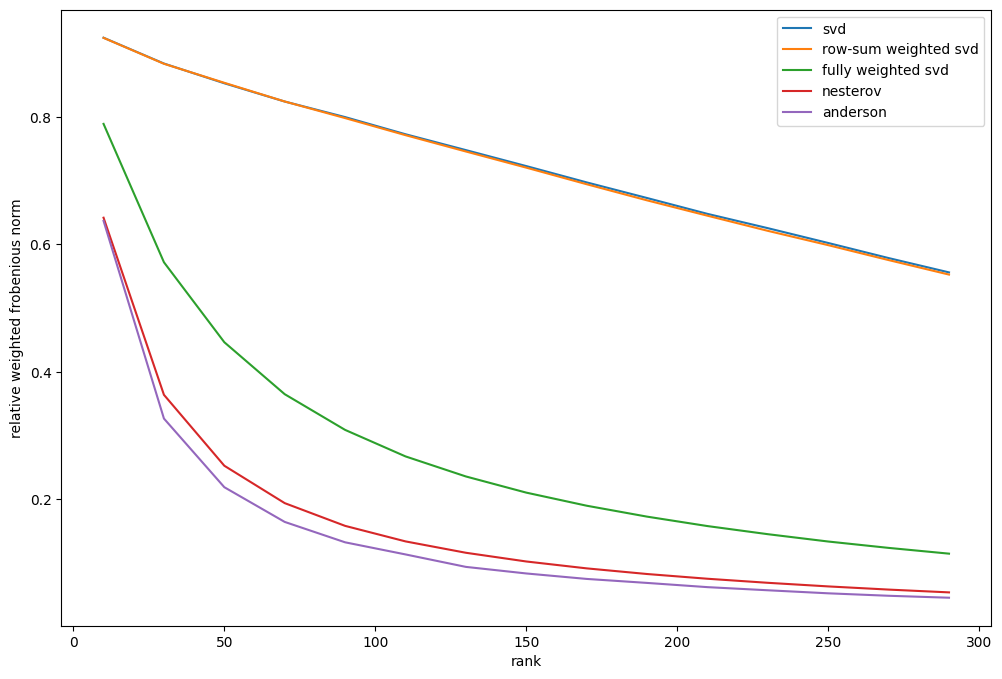

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(rank_range, svd_err, label="svd")
plt.plot(rank_range, wsvd_err, label="row-sum weighted svd")
plt.plot(rank_range, wwsvd_err, label="fully weighted svd")
plt.plot(rank_range, nesterov_err, label="nesterov")
plt.plot(rank_range, anderson_err, label="anderson")
plt.xlabel("rank")
plt.ylabel("relative weighted frobenious norm")
plt.legend()
plt.show()

Fully weighted SVD works better, as expected.

I expected row-sum weigthed SVD to be better, but it's not.
So either my expectations, or my implementation is wrong.

In [20]:
torch.manual_seed(2222)
weight = torch.rand(*w.shape) ** 100
weight += (torch.arange(1, 3073) / 3072)[:, None]
weight /= weight.max()

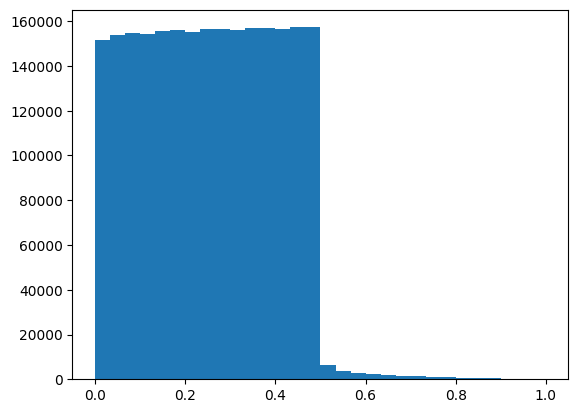

In [21]:
plt.hist(weight.numpy().ravel(), bins=30)
plt.show()

torch.Size([3072])


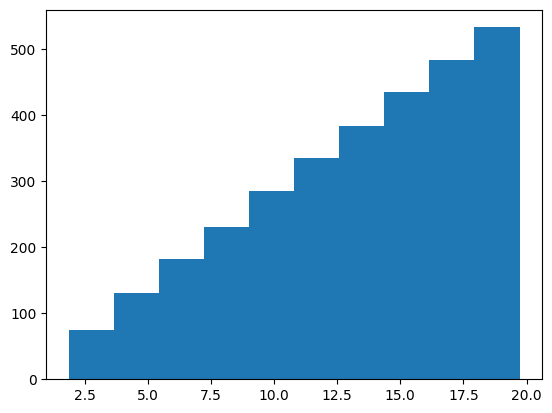

In [22]:
diag_weight = torch.sqrt(weight.sum(1))
print(diag_weight.shape)
plt.hist(diag_weight)
plt.show()

In [23]:
svd_err = []
wsvd_err = []
wwsvd_err = []
nesterov_err = []
anderson_err = []

weight = weight.to(device)
diag_weight = diag_weight.to(device)

norm_w = weighted_frob(w, weight)

rank_range = range(10, 300, 20)

for k in tqdm(rank_range):
    print(k)
    # SVD
    a, b = get_low_rank(w, k)

    # SVD with weights from first article
    aa, bb = get_low_rank(torch.diag(diag_weight) @ w, k)
    aa = torch.diag(1 / diag_weight) @ aa

    # Weighted SVD from https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf
    aaa, bbb = weighted_svd(w, k, weight)

    na, nb = nesterov(w, k, weight)
    
    anderson_a, anderson_b = anderson(w, k, weight)
    
    svd_err.append(weighted_frob(w - a @ b, weight) / norm_w)
    wsvd_err.append(weighted_frob(w - aa @ bb, weight) / norm_w)
    wwsvd_err.append(weighted_frob(w - aaa @ bbb, weight) / norm_w)
    nesterov_err.append(weighted_frob(w - na @ nb, weight) / norm_w)
    anderson_err.append(weighted_frob(w - anderson_a @ anderson_b, weight) / norm_w)
    

  0%|          | 0/15 [00:00<?, ?it/s]

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290


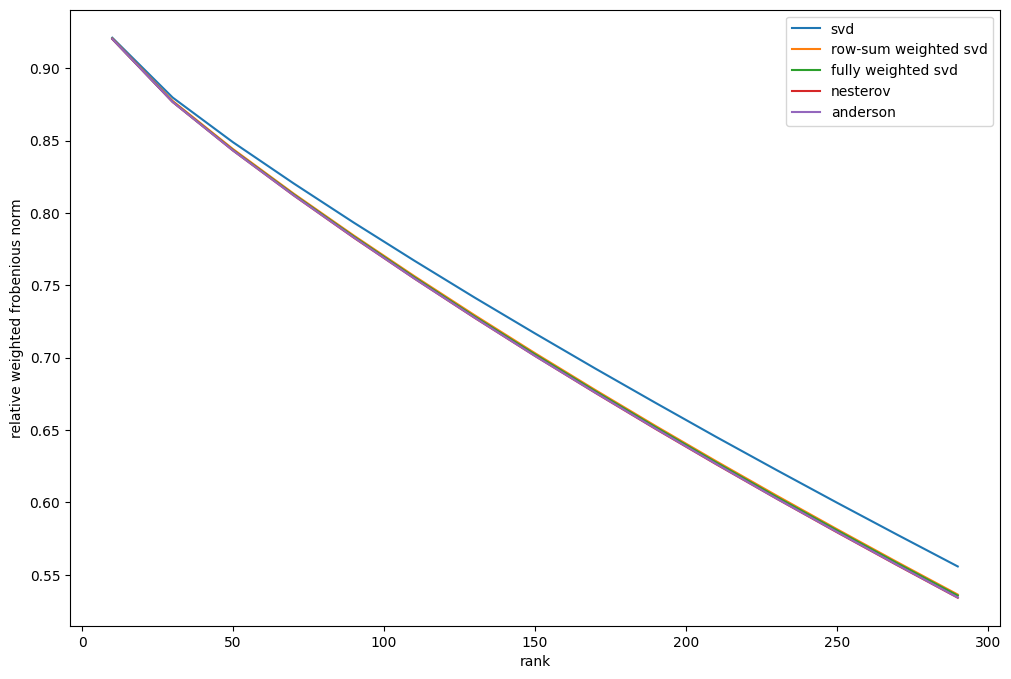

In [24]:

plt.figure(figsize=(12, 8))
plt.plot(rank_range, svd_err, label="svd")
plt.plot(rank_range, wsvd_err, label="row-sum weighted svd")
plt.plot(rank_range, wwsvd_err, label="fully weighted svd")
plt.plot(rank_range, nesterov_err, label="nesterov")
plt.plot(rank_range, anderson_err, label="anderson")
plt.xlabel("rank")
plt.ylabel("relative weighted frobenious norm")
plt.legend()
plt.show()

Apparently, my expectations and my implementation was correct, but the results heavily depends on the distribution of weights in weighting matrix.